# Pytorch 怎麼使用Pool、Activation function和宣告自己想建立的結構<br>


<font size=4> 
   
   1. Pool example <br><br>
   2. Activation example: 要怎麼建立自己的Activation function <br><br>
   3. 建立自己設計的積木
      > - ResBlock (ResNet) <br>
      > - Depthwise Conv. (MobileNet) <br>
      > - DenseBlock (DenseNet) <br>
      > - InceptionBlock (InceptionNetv1 = GoogLeNet) <br>
    
</font>

import torch
import torch.nn as nn
import numpy as np

------------------
# Pool example
<font size=4>
- 1. Max-pooling: ks=2, stride=2<br>
- 2. Average pooling : ks=2, stride=2<br>
- 3. Global Average Pooling (GAP)<br>
</font>

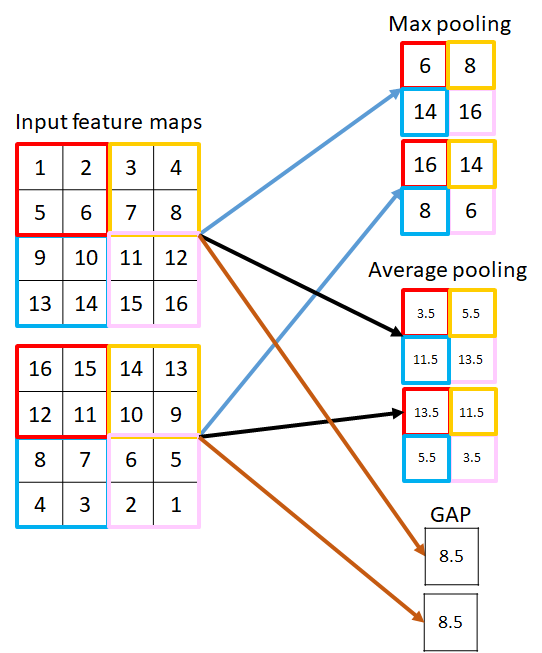

In [8]:
InputImage = torch.FloatTensor([
                                [[ 1, 2, 3, 4],
                                 [ 5, 6, 7, 8],
                                 [ 9,10,11,12],
                                 [13,14,15,16]],
                                [[16,15,14,13],
                                 [12,11,10, 9],
                                 [ 8, 7, 6, 5],
                                 [ 4, 3, 2, 1]]
                                ]).unsqueeze(axis=0) # 1*2*3*3

maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # 
print('Input feature map:\n{}'.format(InputImage))
output = maxpool(InputImage)
print('Output feature map after max pooling:\n{}'.format(output))

Input feature map:
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]],

         [[16., 15., 14., 13.],
          [12., 11., 10.,  9.],
          [ 8.,  7.,  6.,  5.],
          [ 4.,  3.,  2.,  1.]]]])
Output feature map after max pooling:
tensor([[[[ 6.,  8.],
          [14., 16.]],

         [[16., 14.],
          [ 8.,  6.]]]])


In [10]:
maxpool = nn.AvgPool2d(kernel_size=2, stride=2) #
print('Input feature map:\n{}'.format(InputImage))
output = maxpool(InputImage)
print('Output feature map after max pooling:\n{}'.format(output))

Input feature map:
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]],

         [[16., 15., 14., 13.],
          [12., 11., 10.,  9.],
          [ 8.,  7.,  6.,  5.],
          [ 4.,  3.,  2.,  1.]]]])
Output feature map after max pooling:
tensor([[[[ 3.5000,  5.5000],
          [11.5000, 13.5000]],

         [[13.5000, 11.5000],
          [ 5.5000,  3.5000]]]])


In [11]:
output = nn.functional.adaptive_avg_pool2d(InputImage, 1).reshape(InputImage.shape[0], -1)
print('Input feature map:\n{}'.format(InputImage))
print('Output feature map after max pooling:\n{}'.format(output))

Input feature map:
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]],

         [[16., 15., 14., 13.],
          [12., 11., 10.,  9.],
          [ 8.,  7.,  6.,  5.],
          [ 4.,  3.,  2.,  1.]]]])
Output feature map after max pooling:
tensor([[8.5000, 8.5000]])


---------------------------------
# Activate example
<font size=4>
- 1. Sigmoid<br>
- 2. tanh<br>
- 3. ReLU<br>
- 4. Leaky ReLU (p=0.1)<br>
- 5. Mish<br>
</font>


In [30]:
x_np = np.linspace(-3,3,51)
x_tensor = torch.FloatTensor(x_np)

In [31]:
output_sigmoid = nn.Sigmoid()(x_tensor)
output_tanh = nn.Tanh()(x_tensor)
output_ReLU = nn.ReLU()(x_tensor)
output_LkReLU = nn.LeakyReLU(0.1)(x_tensor)
output_mish = nn.Mish()(x_tensor)

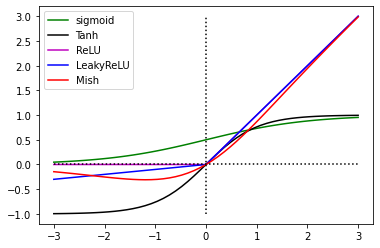

In [38]:
import matplotlib.pyplot as plt
plt.figure
plt.plot(x_tensor,output_sigmoid,'g')
plt.plot(x_tensor,output_tanh,'k')
plt.plot(x_tensor,output_ReLU,'m')
plt.plot(x_tensor,output_LkReLU,'b')
plt.plot(x_tensor,output_mish,'r')
plt.legend(['sigmoid','Tanh','ReLU','LeakyReLU','Mish'])
plt.plot([-3,3],[0,0],':k')
plt.plot([0,0],[-1,3],':k')
plt.show()

# 那要怎麼建立自己的Activation function
<font size=3>我們用MISH當作例子來建立自己的Activation function </font>

$$
mish(x)= x*tanh(ln(1+e^x))
$$


In [42]:
class Mish(nn.Module):    
    #Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
    #https://arxiv.org/abs/1908.08681v1
    def __init__(self):
        super().__init__()  
    def forward(self, x):
        return x *( torch.tanh(nn.functional.softplus(x))) # softplus = torch.log(1+torch.exp(x))

In [40]:
x = torch.FloatTensor([3])
print(nn.functional.softplus(x))
print(torch.log(1+torch.exp(x)))

tensor([3.0486])
tensor([3.0486])


In [44]:
output_mish1 = nn.Mish()(x)
output_mish2 = Mish()(x)
print(output_mish1)
print(output_mish2)

tensor([2.9865])
tensor([2.9865])


# 建立自己設計的積木
<font size=4>
    1. ResBlock (ResNet) <br>
    2. Depthwise Conv. (MobileNet) <br>
    3. DenseBlock (DenseNet) <br>
    4. InceptionBlock (InceptionNetv1 = GoogLeNet) <br>
    
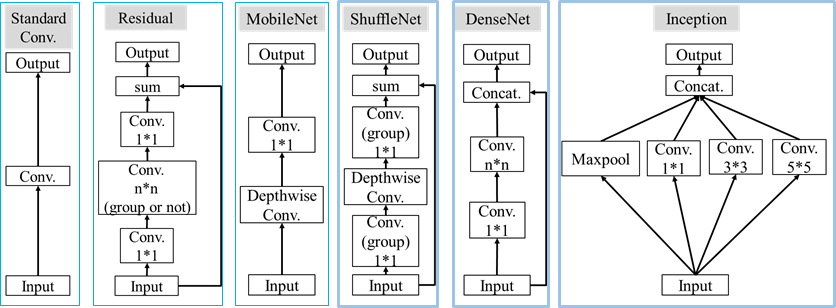

<font size=4>
    1. ResBlock (ResNet) <br>

In [57]:
class ResBlock(nn.Module):
    def __init__( self, inplanes: int, planes: int,  stride: int = 1) -> None:
        super(ResBlock, self).__init__()
        norm_layer = nn.BatchNorm2d
        
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,padding=1)
        self.bn2 = norm_layer(planes)
        
        self.conv3 = nn.Conv2d(planes, inplanes, kernel_size=1, stride=stride)
        self.bn3 = norm_layer(inplanes)       
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        
        out += identity
        out = self.relu(out)
        return out
ResConv = ResBlock(inplanes=3,planes=10)
print(ResConv)


ResBlock(
  (conv1): Conv2d(3, 10, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(10, 3, kernel_size=(1, 1), stride=(1, 1))
  (bn3): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


<font size=4> 看上面可能還看不出來我們打得程式碼和實際我們想像的有沒有一樣<br>
    我們採用onnx file輸出，並且用[Netron](https://netron.app/)來做視覺化呈現

In [ ]:
dummy_inpurt = torch.rand(1,3,10,10)
out=ResConv(dummy_inpurt)
torch.onnx.export(ResConv, dummy_inpurt, './ResConv.onnx', opset_version=11, example_outputs=out)

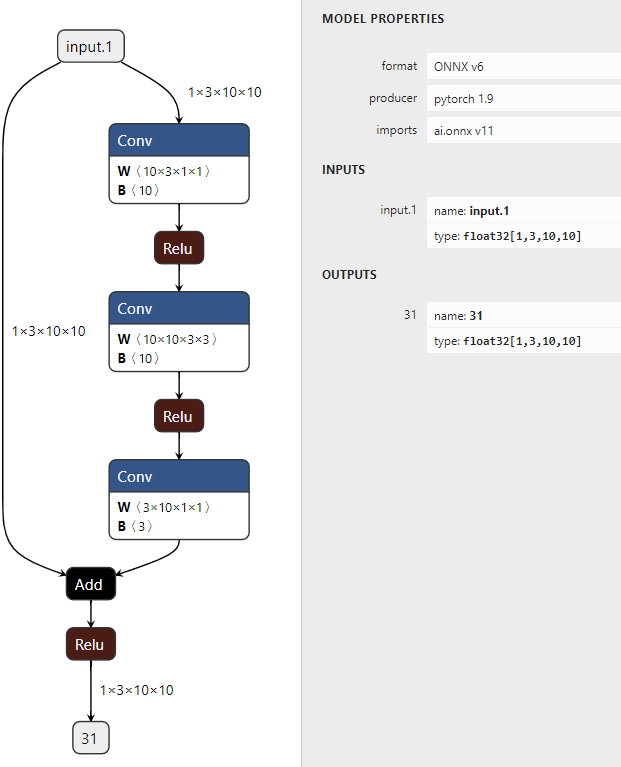

<font size=4>
    2. Depthwise Conv. (MobileNet) <br>
Depthwise = Group conv ( group = inchannel = outchannel)

In [64]:
class DepthwiseSeparable_Conv(nn.Module):
    def __init__( self, inplanes: int, outplanes: int, stride: int = 1) -> None:
        super(DepthwiseSeparable_Conv, self).__init__()
        norm_layer = nn.BatchNorm2d
        
        self.conv1 = nn.Conv2d(inplanes, inplanes, 3, stride, 1, groups=inplanes, bias=False)
        self.bn1 = norm_layer(inplanes)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = norm_layer(outplanes)
     
    def  forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        return out
DSconv = DepthwiseSeparable_Conv(inplanes=3,outplanes=10)
print(DSconv)
        
dummy_inpurt = torch.rand(1,3,10,10)
out=DSconv(dummy_inpurt)
torch.onnx.export(DSconv, dummy_inpurt, './DSconv.onnx', opset_version=11, example_outputs=out)        


DepthwiseSeparable_Conv(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3, bias=False)
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(3, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


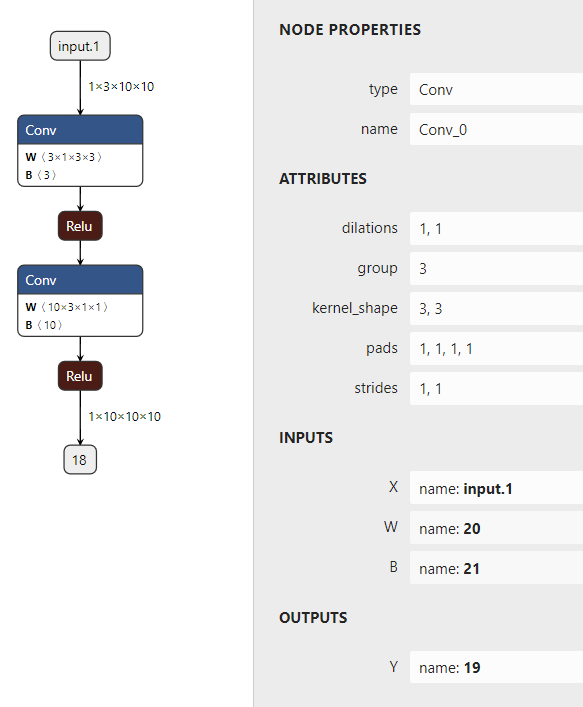

<font size=4>前面一堆機component宣告，在forward要一個一個打出來，有沒有辦法包的更點單，
可以用nn.Sequential來打包。

In [66]:
class DepthwiseSeparable_Conv(nn.Module):
    def __init__( self, inplanes: int, outplanes: int, stride: int = 1) -> None:
        super(DepthwiseSeparable_Conv, self).__init__()
        norm_layer = nn.BatchNorm2d
        
        self.conv_dws =  nn.Sequential(
            nn.Conv2d(inplanes, inplanes, 3, stride, 1, groups=inplanes, bias=False),
            norm_layer(inplanes),
            nn.ReLU(inplace=True),

            nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=1, padding=0, bias=False),
            norm_layer(outplanes),
            nn.ReLU(inplace=True),
        )
     
    def  forward(self, x):
        out = self.conv_dws(x)
        return out
DSconv = DepthwiseSeparable_Conv(inplanes=3,outplanes=10)
print(DSconv)
dummy_inpurt = torch.rand(1,3,10,10)
out=DSconv(dummy_inpurt)
torch.onnx.export(DSconv, dummy_inpurt, './DSconv.onnx', opset_version=11, example_outputs=out) 

DepthwiseSeparable_Conv(
  (conv_dws): Sequential(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3, bias=False)
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(3, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
)


<font size=4>
    3. DenseBlock (DenseNet) <br>
    DenseNet靠每次Conv.都是用少channel的量進行運算，然後幾次Conv.再將所有的特徵圖串聯在一起，這時候的特徵數夠多後，再利用1*1 Conv.降維度的同時進行特徵圖融合。

<img src="https://pytorch.org/assets/images/densenet1.png" style="border:none;">

    

In [72]:
class DenseBlock(nn.Module):
    def __init__(self, inplanes, outplanes, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(inplanes, outplanes, kernel_size=3, stride=1,
                               padding=1, bias=False)
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        return torch.cat([x, out], 1)
    
DenseB = DenseBlock(inplanes=3,outplanes=10)
print(DenseB)
dummy_inpurt = torch.rand(1,3,10,10)
out=DenseB(dummy_inpurt)
torch.onnx.export(DenseB, dummy_inpurt, './DenseBlock.onnx', opset_version=11, example_outputs=out) 

DenseBlock(
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


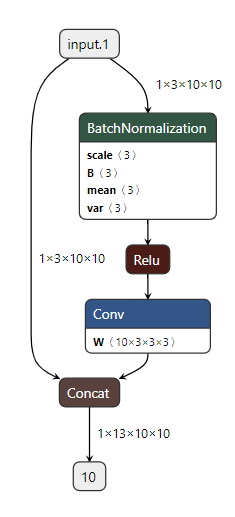

<font size=4>
    4. InceptionBlock (InceptionNetv1 = GoogLeNet) <br>
    
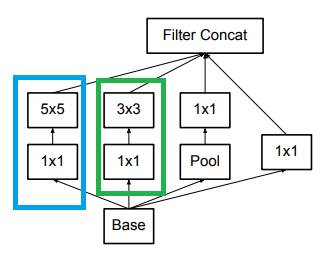

In [81]:
# Inception模块
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_chanel_1, out_channel_3_reduce, out_channel_3,
                 out_channel_5_reduce, out_channel_5, out_channel_pool):
        super(InceptionBlock, self).__init__()

        self.block1 = nn.Conv2d(in_channels=in_channels, out_channels=out_chanel_1, kernel_size=1)
        
        self.block2 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channel_3_reduce, kernel_size=1),
                      nn.Conv2d(in_channels=out_channel_3_reduce, out_channels=out_channel_3, kernel_size=3, padding=1))

        self.block3 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channel_5_reduce, kernel_size=1),
                      nn.Conv2d(in_channels=out_channel_5_reduce, out_channels=out_channel_5, kernel_size=5, padding=2))

        self.block4 = nn.Sequential(nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
                     nn.Conv2d(in_channels=in_channels, out_channels=out_channel_pool, kernel_size=1))
    def forward(self, x):
        out1 = self.block1(x)
        out2 = self.block2(x)
        out3 = self.block3(x)
        out4 = self.block4(x)
        out = torch.cat([out1, out2, out3, out4], dim=1)
        return out

   
InceptionB = InceptionBlock(in_channels=128,
                            out_chanel_1=160, 
                            out_channel_3_reduce=112, out_channel_3=224,
                            out_channel_5_reduce=24, out_channel_5=64, 
                            out_channel_pool=64)
print(InceptionB)
dummy_inpurt = torch.randn(1,128,10,10)
out=InceptionB(dummy_inpurt)
torch.onnx.export(InceptionB, dummy_inpurt, './InceptionBlock.onnx', opset_version=11, example_outputs=out) 

InceptionBlock(
  (block1): Conv2d(128, 160, kernel_size=(1, 1), stride=(1, 1))
  (block2): Sequential(
    (0): Conv2d(128, 112, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(112, 224, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (block3): Sequential(
    (0): Conv2d(128, 24, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (block4): Sequential(
    (0): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
  )
)


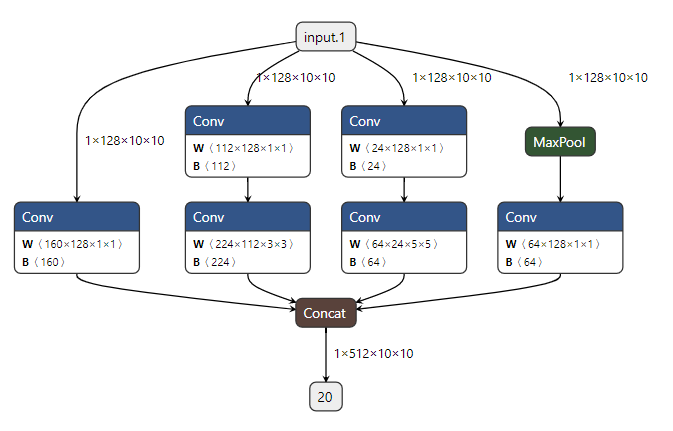